In [9]:
import jax
import jax.numpy as jnp
import numpy as np
from scipy.integrate import solve_bvp
from functools import partial
import pyomo.environ as pyo
from pyomo.opt import TerminationCondition
import matplotlib.pyplot as plt


[FORMULA PLACEHOLDER]

In [10]:
def matern_kernel_0p5(t_i, t_j, sigma, rho):
    d = jnp.abs(t_i - t_j)
    return sigma**2 * jnp.exp(-d / rho)

def integrated_matern_kernel_0p5(t_i, t_j, sigma, rho):
    s = t_i - t_j
    d = jnp.abs(s)

    def if_s_neg():
        return rho * (sigma**2) * (jnp.exp(-d / rho) - jnp.exp(-t_j / rho))

    def if_s_non_neg():
        return rho * (sigma**2) * (2 - jnp.exp(-d / rho) - jnp.exp(-t_j / rho))

    return jax.lax.cond(s < 0, if_s_neg, if_s_non_neg)

@partial(jax.jit, static_argnums=(2,))
def integrated_matern_kernel_matrices_0p5(t_i, t_j, sigma, rho):
    K = jax.vmap(
        jax.vmap(matern_kernel_0p5, in_axes=(None, 0, None, None)),
        in_axes=(0, None, None, None),)(t_i, t_j, sigma, rho)
    K_tilde = jax.vmap(
        jax.vmap(integrated_matern_kernel_0p5, in_axes=(None, 0, None, None)),
        in_axes=(0, None, None, None),)(t_i, t_j, sigma, rho)
    return K, K_tilde

# Neoclassical Growth Benchmark solution: the function is defined in neoclassical_growth_benchmark.py
def neoclassical_growth_benchmark(a, delta, r, sigma_crra, k_0, t_grid, perturb_k=1e-4):
    #a: capital share
    #delta: depreciation 
    #r: discount rate
    #sigma_crra: the constant relative risk aversion coefficient
    #k_0: initial condition for capital
    #t_grid: The grid for time where we want to solve the problem over (0,t_1,...,T)
    #perturb_k : how far away from the steady-state capital you want the trajectory be at the terminal time, T

    k_ss = ((delta + r) / a) ** (1 / (a - 1))
    c_ss = a * k_ss**a - -delta * k_ss
    # perturb the final value of the capital at T to help convergence
    k_T = k_ss - perturb_k

    def ODE(t, y):
        k = y[0]
        c = y[1]
        return jnp.vstack(
            (
                k**a - c - delta * k,
                (c / sigma_crra) * (a * k ** (a - 1) - r - delta),
            )
        )

    def bc(ya, yb):
        return jnp.array([ya[0] - k_0, yb[0] - k_T]) #boundary condition, k(0) = k_0, k(T) = k_T

    iv = 1 * jnp.ones((2, t_grid.size))
    solution = solve_bvp(ODE, bc, t_grid, iv)

    # the "solution" is an interpolator already, can just unpack
    T_max = t_grid[-1]

    def interpolate_solution(t_grid):
        if t_grid[-1] > T_max:
            raise ValueError("Extrapolation not supported")
        val = solution.sol(t_grid)
        return val[0], val[1]

    return interpolate_solution

Setting up the parameters

In [11]:
a = 1 / 3
delta = 0.1
rho_hat = 0.11
k_0 = 1.0 #k_0 is the state variable initial conditions here, i.e., x_0
sigma = 1.0
rho = 10
solver_type = "ipopt"
train_T = 40.0
train_points = 41
test_T = 50
test_points = 100
benchmark_T = 60.0
benchmark_points = 300
train_points_list = None
lambda_p = 0.0 #Smooting penalty for the optimizer, This is purely because of the DAE term mu*c = 1
verbose = False



Traning/testing grids and kernel matrices. 

In [12]:
# if passing in `train_points` then doesn't us a grid.  Otherwise, uses linspace
if train_points_list is None:
    train_data = jnp.linspace(0, train_T, train_points)
else:
    train_data = jnp.array(train_points_list)
test_data = jnp.linspace(0, test_T, test_points)
benchmark_grid = jnp.linspace(0, benchmark_T, benchmark_points)

# Construct kernel matrices
N = len(train_data)
K, K_tilde = integrated_matern_kernel_matrices_0p5(
    train_data, train_data, sigma, rho
)
K = np.array(K)  # pyomo doesn't support jax arrays
K_tilde = np.array(K_tilde)



Setting up the Pyomo model

In [13]:
# Create pyomo model and variables
m = pyo.ConcreteModel()
m.I = range(N)
m.alpha_mu = pyo.Var(m.I, within=pyo.Reals, initialize=0.0)
m.alpha_c = pyo.Var(m.I, within=pyo.Reals, initialize=0.0)
m.alpha_k = pyo.Var(m.I, within=pyo.Reals, initialize=0.0) #k is the state variable here, i.e., x
m.c_0 = pyo.Var(within=pyo.NonNegativeReals, initialize=k_0**a - delta * k_0)
m.mu_0 = pyo.Var(within=pyo.NonNegativeReals, initialize=k_0**a - delta * k_0)

# Map kernels to variables. Pyomo doesn't support c_0 + K_tilde @ m.alpha_c
def mu(m, i):
    return m.mu_0 + sum(K_tilde[i, j] * m.alpha_mu[j] for j in m.I)

def c(m, i):
    return m.c_0 + sum(K_tilde[i, j] * m.alpha_c[j] for j in m.I)

def k(m, i): #k is the state variable here, i.e., x
    return k_0 + sum(K_tilde[i, j] * m.alpha_k[j] for j in m.I)

def dmu_dt(m, i):
    return sum(K[i, j] * m.alpha_mu[j] for j in m.I)

def dk_dt(m, i): #dk_dt is the state variable's derivative here, i.e., dx_dt
    return sum(K[i, j] * m.alpha_k[j] for j in m.I)


Solving the model

In [14]:
# Define constraints and objective for model and solve
@m.Constraint(m.I)  # for each index in m.I
def resource_constraint(m, i):
    return dk_dt(m, i) == k(m, i) ** a - delta * k(m, i) - c(m, i)

@m.Constraint(m.I)  # for each index in m.I
def euler(m, i):
    return dmu_dt(m, i) == -mu(m, i) * (a * k(m, i) ** (a - 1) - delta - rho_hat)

@m.Constraint(m.I)  # for each index in m.I
def shadow_price(m, i):
    return mu(m, i) * c(m, i) == 1.0


@m.Objective(sense=pyo.minimize)
def min_norm(m):  # alpha @ K @ alpha not supported by pyomo
    return sum(K[i, j] * m.alpha_mu[i] * m.alpha_mu[j] for i in m.I for j in m.I)+sum(K[i, j] * m.alpha_k[i] * m.alpha_k[j] for i in m.I for j in m.I) + lambda_p*(sum(K[i, j] * m.alpha_c[i] * m.alpha_c[j] for i in m.I for j in m.I)
    + sum(K[i, j] * m.alpha_k[i] * m.alpha_k[j] for i in m.I for j in m.I)+ sum(K[i, j] * m.alpha_mu[i] * m.alpha_mu[j] for i in m.I for j in m.I)
    )
    #lambda_p makes sure the optimizer returns smooth (non-wiggly solutions in the extrapolation), we set it to zero
solver = pyo.SolverFactory(solver_type)
options = {
    "tol": 1e-8,  # Tighten the tolerance for optimality
    "dual_inf_tol": 1e-8,  # Tighten the dual infeasibility tolerance
    "constr_viol_tol": 1e-8,  # Tighten the constraint violation tolerance
    "max_iter": 2000,  # Adjust the maximum number of iterations if needed
}  # See https://coin-or.github.io/Ipopt/OPTIONS.html for more details # can add options here.   See https://coin-or.github.io/Ipopt/OPTIONS.html#OPTIONS_AMPL
results = solver.solve(m, tee=verbose, options=options)
if not results.solver.termination_condition == TerminationCondition.optimal:
    print(str(results.solver))  # raise exception?

alpha_c = jnp.array([pyo.value(m.alpha_c[i]) for i in m.I])
alpha_k = jnp.array([pyo.value(m.alpha_k[i]) for i in m.I])
c_0 = pyo.value(m.c_0)


Building the JAX interpolator and evaluating on the test grid.

In [15]:
# Interpolator using training data
@jax.jit
def kernel_solution(test_data):
    # pointwise comparison test_data to train_data
    K_test, K_tilde_test = integrated_matern_kernel_matrices_0p5(
        test_data, train_data, sigma, rho
    )
    c_test = c_0 + K_tilde_test @ alpha_c
    k_test = k_0 + K_tilde_test @ alpha_k
    return k_test, c_test

sol_benchmark = neoclassical_growth_benchmark(
    a, delta, rho_hat, 1.0, k_0, benchmark_grid
)

# Generate test_data and compare to the benchmark
k_benchmark, c_benchmark = sol_benchmark(test_data)
k_test, c_test = kernel_solution(test_data)

k_rel_error = jnp.abs(k_benchmark - k_test) / k_benchmark
c_rel_error = jnp.abs(c_benchmark - c_test) / c_benchmark
print(
    f"solve_time(s) = {results.solver.Time}, E(|rel_error(k)|) = {k_rel_error.mean()}, E(|rel_error(c)|) = {c_rel_error.mean()}"
)

results_dict = {
    "t_train": train_data,
    "t_test": test_data,
    "k_test": k_test,
    "c_test": c_test,
    "k_benchmark": k_benchmark,
    "c_benchmark": c_benchmark,
    "k_rel_error": k_rel_error,
    "c_rel_error": c_rel_error,
    "alpha_c": alpha_c,
    "alpha_k": alpha_k,
    "c_0": c_0,
    "solve_time": results.solver.Time,
    "kernel_solution": kernel_solution,  # interpolator
    "benchmark_solution": sol_benchmark,  # interpolator
}

solve_time(s) = 0.21670770645141602, E(|rel_error(k)|) = 0.00036802463000640273, E(|rel_error(c)|) = 0.0006670550792478025


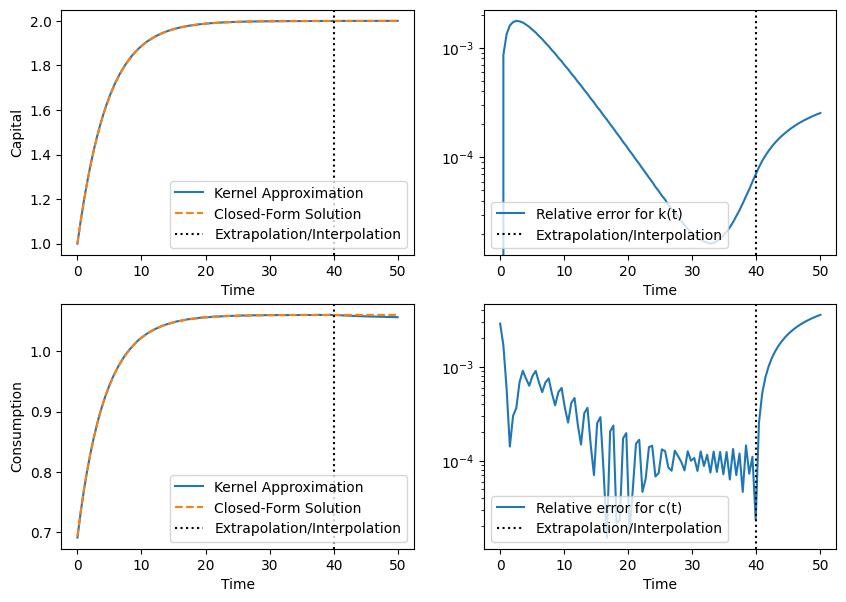

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(10, 7))
(ax1, ax2), (ax3, ax4) = axes

T = float(train_data.max())

ax1.plot(test_data, k_test, label="Kernel Approximation")
ax1.plot(test_data, k_benchmark, linestyle="--", label="Closed-Form Solution")
ax1.axvline(T, linestyle=":", color="black", label="Extrapolation/Interpolation")
ax1.set_xlabel("Time")
ax1.set_ylabel("Capital")
ax1.legend(loc="lower right")

ax2.plot(test_data, k_rel_error, label="Relative error for k(t)")
ax2.axvline(T, linestyle=":", color="black", label="Extrapolation/Interpolation")
ax2.set_xlabel("Time")
ax2.set_yscale("log")
ax2.legend(loc="lower left")

ax3.plot(test_data, c_test, label="Kernel Approximation")
ax3.plot(test_data, c_benchmark, linestyle="--", label="Closed-Form Solution")
ax3.axvline(T, linestyle=":", color="black", label="Extrapolation/Interpolation")
ax3.set_xlabel("Time")
ax3.set_ylabel("Consumption")
ax3.legend(loc="lower right")

ax4.plot(test_data, c_rel_error, label="Relative error for c(t)")
ax4.axvline(T, linestyle=":", color="black", label="Extrapolation/Interpolation")
ax4.set_xlabel("Time")
ax4.set_yscale("log")
ax4.legend(loc="lower left")

